In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = '/ENPM809K/assignment1'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/ENPM809K/assignment1/cs231n/datasets
/content/drive/My Drive/ENPM809K/assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)
# loss, grad = softmax_loss_vectorized(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.323299
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ We have the CIFAR-10 with 10 classes each class with a probablity of 1/10. At initialization we use randomised weights and the loss is -log(1/C) where C=10 which is nothing but -log(0.1).



In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.426035 analytic: 0.426035, relative error: 1.891000e-08
numerical: 1.903852 analytic: 1.903852, relative error: 5.625104e-09
numerical: 3.559090 analytic: 3.559090, relative error: 6.373249e-09
numerical: 2.399062 analytic: 2.399062, relative error: 8.147401e-09
numerical: 1.019080 analytic: 1.019080, relative error: 1.343745e-08
numerical: -2.340545 analytic: -2.340545, relative error: 8.394228e-10
numerical: -1.235481 analytic: -1.235481, relative error: 3.036651e-08
numerical: -0.553019 analytic: -0.553019, relative error: 4.231782e-08
numerical: 0.721772 analytic: 0.721772, relative error: 4.902116e-08
numerical: 0.804810 analytic: 0.804810, relative error: 2.760829e-08
numerical: 1.001254 analytic: 1.004654, relative error: 1.695121e-03
numerical: -0.150528 analytic: -0.156893, relative error: 2.070496e-02
numerical: -0.876213 analytic: -0.872382, relative error: 2.190887e-03
numerical: 0.600483 analytic: 0.603196, relative error: 2.253772e-03
numerical: -1.152849 ana

In [6]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.323299e+00 computed in 0.249229s
vectorized loss: 2.323299e+00 computed in 0.014181s
Loss difference: 0.000000
Gradient difference: 0.000000


In [7]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 2e-7, 3.5e-7, 5e-5]
regularization_strengths = [1e4, 2e4, 2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# for eachLR, eachRegStr in zip(learning_rates,regularization_strengths):
for eachLR in learning_rates:
  for eachRegStr in regularization_strengths:
    print(" <<<<<<<<<<<<<<<------------------------------>>>>>>>>>>>>>>> ")
    print('lr %e reg %e' % (eachLR, eachRegStr))
    # start_time = time.time()
    # Training the Softmax classifier with each regularization strength for
    # every learning rate. Final 1500 iterations using the training data
    soft = Softmax()
    loss_hist = soft.train(X_train, y_train, learning_rate=eachLR, reg=eachRegStr,
                      num_iters=1500, verbose=False)
    
    # Calculating the accuracy on training and validation data to evaluate the 
    # performance
    y_train_pred = soft.predict(X_train)
    train_accuracy = np.mean(y_train == y_train_pred)
    y_val_pred = soft.predict(X_val)
    val_accuracy = np.mean(y_val == y_val_pred)
    print('training accuracy: %f validation accuracy: %f' % (train_accuracy, val_accuracy))

    # Storing the training and validation accuracy results in the results dict
    results[(eachLR,eachRegStr)] = (train_accuracy,val_accuracy)

    # Check for the best validation accuracy and the best object which gives it
    if val_accuracy > best_val:
      best_val = val_accuracy
      best_softmax = soft

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

 <<<<<<<<<<<<<<<------------------------------>>>>>>>>>>>>>>> 
lr 1.000000e-07 reg 1.000000e+04
training accuracy: 0.332939 validation accuracy: 0.348000
 <<<<<<<<<<<<<<<------------------------------>>>>>>>>>>>>>>> 
lr 1.000000e-07 reg 2.000000e+04
training accuracy: 0.353082 validation accuracy: 0.377000
 <<<<<<<<<<<<<<<------------------------------>>>>>>>>>>>>>>> 
lr 1.000000e-07 reg 2.500000e+04
training accuracy: 0.350633 validation accuracy: 0.365000
 <<<<<<<<<<<<<<<------------------------------>>>>>>>>>>>>>>> 
lr 1.000000e-07 reg 5.000000e+04
training accuracy: 0.325204 validation accuracy: 0.348000
 <<<<<<<<<<<<<<<------------------------------>>>>>>>>>>>>>>> 
lr 2.000000e-07 reg 1.000000e+04
training accuracy: 0.372755 validation accuracy: 0.389000
 <<<<<<<<<<<<<<<------------------------------>>>>>>>>>>>>>>> 
lr 2.000000e-07 reg 2.000000e+04
training accuracy: 0.354531 validation accuracy: 0.370000
 <<<<<<<<<<<<<<<------------------------------>>>>>>>>>>>>>>> 
lr 2.000000e-

/content/drive/My Drive/ENPM809K/assignment1/cs231n/classifiers/softmax.py:112: RuntimeWarning: divide by zero encountered in log
  loss =  np.sum(-np.log(y_p))
/content/drive/My Drive/ENPM809K/assignment1/cs231n/classifiers/softmax.py:126: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/content/drive/My Drive/ENPM809K/assignment1/cs231n/classifiers/softmax.py:126: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)


training accuracy: 0.051551 validation accuracy: 0.045000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.332939 val accuracy: 0.348000
lr 1.000000e-07 reg 2.000000e+04 train accuracy: 0.353082 val accuracy: 0.377000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.350633 val accuracy: 0.365000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.325204 val accuracy: 0.348000
lr 2.000000e-07 reg 1.000000e+04 train accuracy: 0.372755 val accuracy: 0.389000
lr 2.000000e-07 reg 2.000000e+04 train accuracy: 0.354531 val accuracy: 0.370000
lr 2.000000e-07 reg 2.500000e+04 train accuracy: 0.348490 val accuracy: 0.366000
lr 2.000000e-07 reg 5.000000e+04 train accuracy: 0.329918 val accuracy: 0.352000
lr 3.500000e-07 reg 1.000000e+04 train accuracy: 0.370510 val accuracy: 0.379000
lr 3.500000e-07 reg 2.000000e+04 train accuracy: 0.353286 val accuracy: 0.375000
lr 3.500000e-07 reg 2.500000e+04 train accuracy: 0.344816 val accuracy: 0.360000
lr 3.500000e-07 reg 5.000000e+04 train accuracy: 0.

In [8]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.362000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$ True


$\color{blue}{\textit Your Explanation:}$ The SVM loss function is only concerned with the coreect class score being greater than the other class score by the margin. Hence, as long as the new datapoint loss satisfies this condition, the SVM loss remains unchanged. The case where it hurts the SVM loss would probably be a rare occassion. The Softmax loss function takes into account the scores of all the datapoint. And the softmax loss decreases if the true class score is higher. Adding a datapoint decreases the true class score and in turn increases the loss. If the datapoint is too large, then it will cause even greater effect on the softmax loss. 



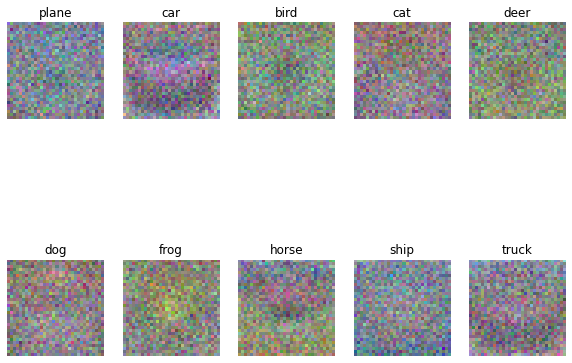

In [9]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])